In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # #                                         # # # # # # #
# # # # # # #             Dimple Surface              # # # # # # # 
# # # # # # #                                         # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [792]:
from veech import *

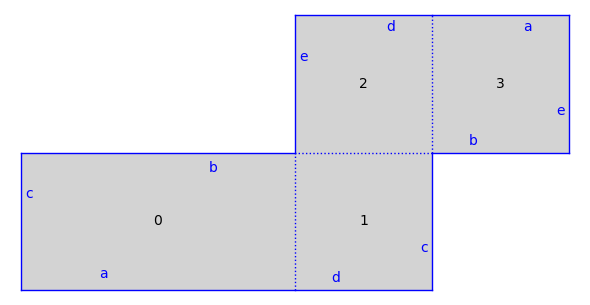

In [794]:
def dimple(x,y):

    def rectangle(a,b):
        return polygons(vertices = [(0,0),(a,0),(a,b),(0,b)])

    P1 = rectangle(x,y)
    Q1 = rectangle(1,y)
    R1 = rectangle(1,1)
    S1 = rectangle(y,1)
    
    s = Surface_list(QQ)

    s.add_polygon(P1)
    s.add_polygon(Q1)
    s.add_polygon(R1)
    s.add_polygon(S1)

    S = SimilaritySurface(s)

    s.set_edge_pairing(0,0,3,2)
    s.set_edge_pairing(0,1,1,3)
    s.set_edge_pairing(0,2,3,0)
    s.set_edge_pairing(0,3,1,1)
    s.set_edge_pairing(1,0,2,2)
    s.set_edge_pairing(1,2,2,0)
    s.set_edge_pairing(2,1,3,3)
    s.set_edge_pairing(2,3,3,1)

    gs = S.graphical_surface()

    gs.make_adjacent(1,2)
    gs.make_adjacent(2,1)      
    
    DS = S.minimal_cover(cover_type='dilation').copy(relabel=True)
    
    return DS, S, gs, s

DS, S, gs, s = dimple(2,1)
S.plot(edge_labels='letter')

In [755]:
plot?

In [608]:
matrices = {}

matrices['1,1'] = [[[0, -1], [1, 2]], [[0, 1], [-1, 0]], [[-1, 0], [0, -1]], [[-1, 0], [-1, -1]]]
matrices['2,1'] = [[[161, 144], [180, 161]], [[119, 180], [-80, -121]], [[121, 180], [-80, -119]], [[65, -53], [-38, 31]], [[121, -180], [80, -119]], [[47, -77], [-119/2, 195/2]], [[23/2, 63/2], [-7/2, -19/2]], [[473/2, -107], [-305/2, 69]], [[-15, -32], [8, 17]], [[21, 11], [-44, -23]], [[23, 11], [-44, -21]], [[-797/4, -1157/4], [-549/4, -797/4]], [[29, 20], [-45, -31]], [[23, -11], [44, -21]], [[-23/2, -63/2], [7/2, 19/2]], [[-19/2, -63/2], [7/2, 23/2]], [[-14, -5], [-39, -14]], [[-161, 144], [180, -161]], [[65, 53], [38, 31]], [[797/4, -1157/4], [-549/4, 797/4]], [[47, 77], [119/2, 195/2]], [[473/2, 107], [305/2, 69]], [[-31, -20], [45, 29]], [[-1, 6], [0, -1]], [[479/2, -689/2], [-333/2, 479/2]], [[-15, -58], [-8, -31]], [[1, 0], [6, 1]], [[-23, -11], [44, 21]], [[-47, 77], [119/2, -195/2]], [[-121, 180], [-80, 119]], [[-31, 20], [-45, 29]], [[-1, 0], [0, -1]]]
matrices['3,1'] = [[[95, 36], [-388/3, -49]], [[111, 84], [440/3, 111]], [[-205, 174], [86, -73]], [[-1, 4], [0, -1]], [[111, -84], [-440/3, 111]], [[929/3, 238], [-566/3, -145]], [[-1, 0], [4, -1]], [[-1, 0], [-4, -1]], [[139, 118], [-86, -73]], [[1, 0], [-4, 1]], [[49, 96], [-24, -47]], [[-49, 36], [200/3, -49]], [[205, -174], [-86, 73]], [[-49, -36], [388/3, 95]], [[-1, 0], [0, -1]]]
matrices['4,1'] = [[[-87, -352], [22, 89]], [[-139, -112], [175, 141]], [[61/4, 325/4], [-13/4, -69/4]], [[1, 0], [-10, 1]], [[-61/4, -325/4], [13/4, 69/4]], [[-45, -88], [22, 43]], [[1, -10], [0, 1]], [[43, -88], [22, -45]], [[71, 28], [-175, -69]], [[73, 37], [-148, -75]], [[-1, 0], [0, -1]]]
matrices['2,2'] = [[[2, 3], [-3, -4]], [[-3, -1], [1, 0]], [[0, 1], [-1, 0]], [[-1, 0], [0, -1]]]
matrices['3,2'] = [[[-1, 6], [0, -1]], [[-43/3, -92/3], [23/3, 49/3]], [[-89/3, 166/3], [23/3, -43/3]], [[43/3, 166/3], [23/3, 89/3]], [[-49/3, -92/3], [23/3, 43/3]], [[-1, 0], [0, -1]]]
matrices['4,2'] = [[[65, 121], [-36, -67]], [[14, -13], [13, -12]], [[-71, -175], [28, 69]], [[-14, -13], [13, 12]], [[-1, 15], [0, -1]], [[1, 0], [3, 1]], [[56, -171], [19, -58]], [[65, -121], [36, -67]], [[-34, -175], [7, 36]], [[-56, -171], [19, 58]], [[-1, 0], [0, -1]]]
matrices['5,2'] = [[[1, -3], [0, 1]], [[-2921/5, -327], [1197/5, 134]], [[-26, -3], [9, 1]], [[-1, 0], [0, -1]]]
matrices['1,3'] = [[[-1, 4], [0, -1]], [[1, 0], [20, 1]], [[47, 36], [184/3, 47]], [[-49, 36], [200/3, -49]], [[47, -36], [-184/3, 47]], [[-1, 0], [0, -1]], [[79, -72], [-260/3, 79]]]
matrices['2,3'] = [[[-39/2, -41/2], [41/2, 43/2]], [[43/2, 41/2], [-41/2, -39/2]], [[-1, -4], [0, -1]], [[-1, 0], [0, -1]], [[39/2, -41/2], [41/2, -43/2]]]

In [543]:
def show_eigenvectors(m):
    m_list = ([m[0][0],m[0][1]],[m[1][0],m[1][1]])
    A = maxima("matrix " + str(m_list))
    eig = A.eigenvectors()
    if len(eig[1]) == 1:
        if len(eig[1][0]) == 1:
            return eig[1][0][0]
        elif len(eig[1][0]) == 2:
            return eig[1][0]
    elif len(eig[1]) == 2:
        return [eig[1][0][0],eig[1][1][0]]

In [807]:
a = Set([1,1])
a

{1}

In [809]:
# # M = matrix(matrices['2,1'][1])
# for M in matrices['2,1']:
#     show(Set(matrix(M).eigenvalues()))

In [839]:
def display_info(parameters, i = 0):
    DS, S, gs, s = dimple(int(parameters[0]),int(parameters[2]))
    all_m = matrices[parameters]
    
    print('parameters = ' + parameters)

    print('\nmatrices and eigenvectors:')
    for j in range(len(all_m)):
        show(j, '.' , matrix(all_m[j]), ' : ' , show_eigenvectors(all_m[j]), ' : eigenvalues = ' , Set(matrix(all_m[j]).eigenvalues()))
           
    print('\nsample matrix:')
    m = matrix(all_m[i])
    show(m)

    print('\nsample eigenvector:')
    eigen = list(m.eigenvectors_right()[0][1][0])
    print(eigen)

    v = S.tangent_vector(0, (43/51,1/51), eigen)
    traj = v.straight_line_trajectory()
    traj.flow(1000)
    print('\nclosed: ' + str(traj.is_closed()))
    print('saddle: ' + str(traj.is_saddle_connection()))
    show(S.plot() + traj.cylinder().plot(alpha=.4, color = 'red') + traj.plot(color='red', thickness = 2))      

parameters = 2,1

matrices and eigenvectors:


0 '.' [161 144]
[180 161] ' : ' [[1,-sqrt(5)/2], [1,sqrt(5)/2]] ' : eigenvalues = ' {0.003105620015141859?, 321.9968943799849?}

1 '.' [ 119  180]
[ -80 -121] ' : ' [1,-2/3] ' : eigenvalues = ' {-1}

2 '.' [ 121  180]
[ -80 -119] ' : ' [1,-2/3] ' : eigenvalues = ' {1}

3 '.' [ 65 -53]
[-38  31] ' : ' [[1,(7*sqrt(47)+17)/53], [1,-(7*sqrt(47)-17)/53]] ' : eigenvalues = ' {0.01041779719269113?, 95.9895822028073?}

4 '.' [ 121 -180]
[  80 -119] ' : ' [1,2/3] ' : eigenvalues = ' {1}

5 '.' [    47    -77]
[-119/2  195/2] ' : ' [[1,(sqrt(83505)-101)/308], [1,-(sqrt(83505)+101)/308]] ' : eigenvalues = ' {144.4930792533098?, 0.006920746690205883?}

6 '.' [ 23/2  63/2]
[ -7/2 -19/2] ' : ' [1,-1/3] ' : eigenvalues = ' {1}

7 '.' [ 473/2   -107]
[-305/2     69] ' : ' [[1,(sqrt(373305)+335)/428], [1,-(sqrt(373305)-335)/428]] ' : eigenvalues = ' {0.003273357495480502?, 305.4967266425045?}

8 '.' [-15 -32]
[  8  17] ' : ' [1,-1/2] ' : eigenvalues = ' {1}

9 '.' [ 21  11]
[-44 -23] ' : ' [1,-2] ' : eigenvalues = ' {-1}

10 '.' [ 23  11]
[-44 -21] ' : ' [1,-2] ' : eigenvalues = ' {1}

11 '.' [ -797/4 -1157/4]
[ -549/4  -797/4] ' : ' [[1,(3*sqrt(70577))/1157], [1,-(3*sqrt(70577))/1157]] ' : eigenvalues = ' {-398.4974905739091?, -0.002509426090889098?}

12 '.' [ 29  20]
[-45 -31] ' : ' [1,-3/2] ' : eigenvalues = ' {-1}

13 '.' [ 23 -11]
[ 44 -21] ' : ' [1,2] ' : eigenvalues = ' {1}

14 '.' [-23/2 -63/2]
[  7/2  19/2] ' : ' [1,-1/3] ' : eigenvalues = ' {-1}

15 '.' [-19/2 -63/2]
[  7/2  23/2] ' : ' [1,-1/3] ' : eigenvalues = ' {1}

16 '.' [-14  -5]
[-39 -14] ' : ' [[1,sqrt(195)/5], [1,-sqrt(195)/5]] ' : eigenvalues = ' {-27.96424004376894?, -0.03575995623105883?}

17 '.' [-161  144]
[ 180 -161] ' : ' [[1,-sqrt(5)/2], [1,sqrt(5)/2]] ' : eigenvalues = ' {-0.003105620015141859?, -321.9968943799849?}

18 '.' [65 53]
[38 31] ' : ' [[1,-(7*sqrt(47)+17)/53], [1,(7*sqrt(47)-17)/53]] ' : eigenvalues = ' {0.01041779719269113?, 95.9895822028073?}

19 '.' [  797/4 -1157/4]
[ -549/4   797/4] ' : ' [[1,(3*sqrt(70577))/1157], [1,-(3*sqrt(70577))/1157]] ' : eigenvalues = ' {0.002509426090889098?, 398.4974905739091?}

20 '.' [   47    77]
[119/2 195/2] ' : ' [[1,-(sqrt(83505)-101)/308], [1,(sqrt(83505)+101)/308]] ' : eigenvalues = ' {144.4930792533098?, 0.006920746690205883?}

21 '.' [473/2   107]
[305/2    69] ' : ' [[1,-(sqrt(373305)+335)/428], [1,(sqrt(373305)-335)/428]] ' : eigenvalues = ' {0.003273357495480502?, 305.4967266425045?}

22 '.' [-31 -20]
[ 45  29] ' : ' [1,-3/2] ' : eigenvalues = ' {-1}

23 '.' [-1  6]
[ 0 -1] ' : ' [1,0] ' : eigenvalues = ' {-1}

24 '.' [ 479/2 -689/2]
[-333/2  479/2] ' : ' [[1,(3*sqrt(25493))/689], [1,-(3*sqrt(25493))/689]] ' : eigenvalues = ' {478.9979123082287?, 0.002087691771308835?}

25 '.' [-15 -58]
[ -8 -31] ' : ' [[1,(2*sqrt(33)+4)/29], [1,-(2*sqrt(33)-4)/29]] ' : eigenvalues = ' {-45.97825058615212?, -0.02174941384788536?}

26 '.' [1 0]
[6 1] ' : ' [0,1] ' : eigenvalues = ' {1}

27 '.' [-23 -11]
[ 44  21] ' : ' [1,-2] ' : eigenvalues = ' {-1}

28 '.' [   -47     77]
[ 119/2 -195/2] ' : ' [[1,-(sqrt(83505)+101)/308], [1,(sqrt(83505)-101)/308]] ' : eigenvalues = ' {-144.4930792533098?, -0.006920746690205883?}

29 '.' [-121  180]
[ -80  119] ' : ' [1,2/3] ' : eigenvalues = ' {-1}

30 '.' [-31  20]
[-45  29] ' : ' [1,3/2] ' : eigenvalues = ' {-1}

31 '.' [-1  0]
[ 0 -1] ' : ' [[1,0],[0,1]] ' : eigenvalues = ' {-1}


sample matrix:


[ 121  180]
[ -80 -119]


sample eigenvector:
[1, -2/3]

closed: True
saddle: False


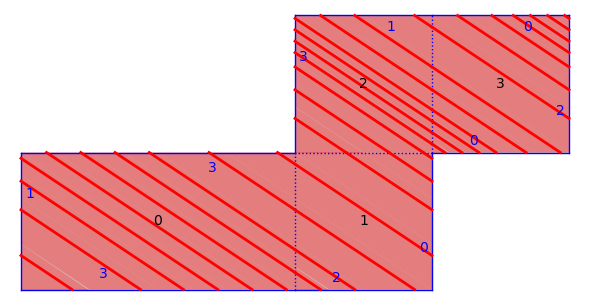

In [840]:
display_info('2,1',2)

In [819]:
# tangent_vector?


closed: False
saddle: False


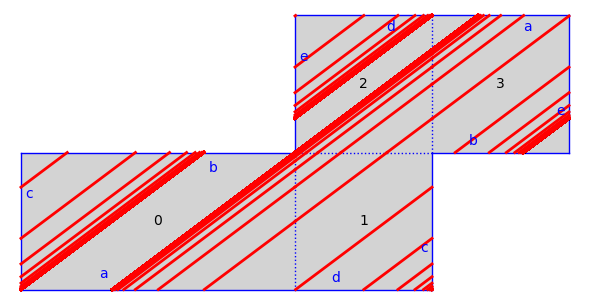

In [835]:
# x = AA(sqrt(2) + sqrt(3))
# print(x)
# v = S.tangent_vector(0, (43/51,1/51), [1,3/4])
v = S.tangent_vector(0, (0.00000001 + 4/4,1/4), [4,3])
traj = v.straight_line_trajectory()
traj.flow(-1000)
traj.flow(1000)
print('\nclosed: ' + str(traj.is_closed()))
print('saddle: ' + str(traj.is_saddle_connection()))
# show(S.plot() + traj.cylinder().plot(alpha=.4, color = 'red') + traj.plot(color='red', thickness = 2))      
show(S.plot() + traj.plot(color='red', thickness = 2))      



path: [0,5]
0. not closed, saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


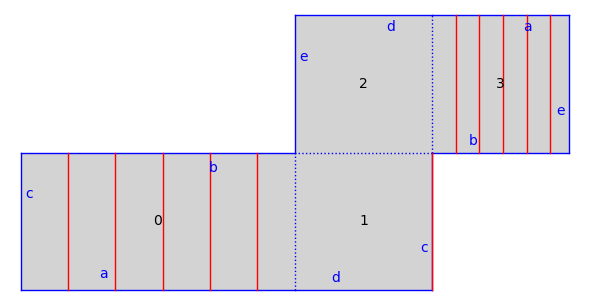


path: [1,5]
0. not closed, not saddle.
1. not closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. not closed, not saddle.
5. not closed, not saddle.


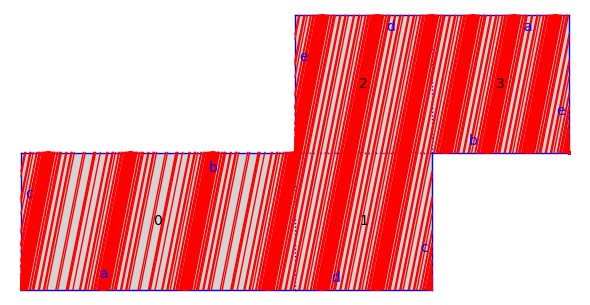


path: [2,5]
0. not closed, not saddle.
1. closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. closed, not saddle.
5. not closed, not saddle.


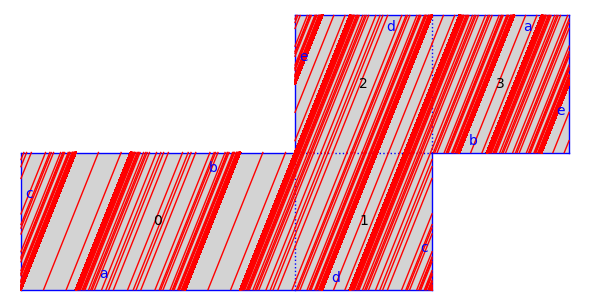


path: [3,5]
0. closed, not saddle.
1. not closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. not closed, not saddle.
5. closed, not saddle.


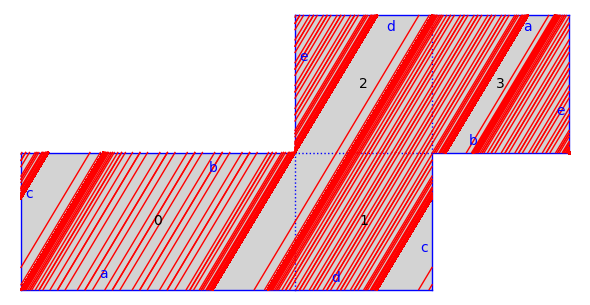


path: [4,5]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


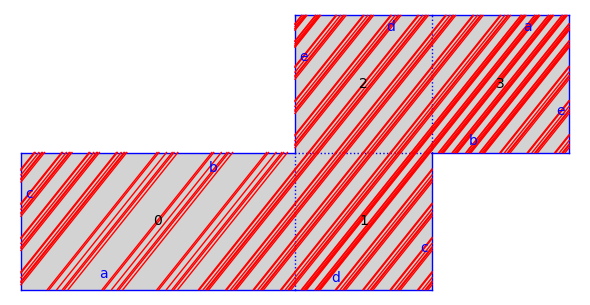


path: [0,6]
0. not closed, saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


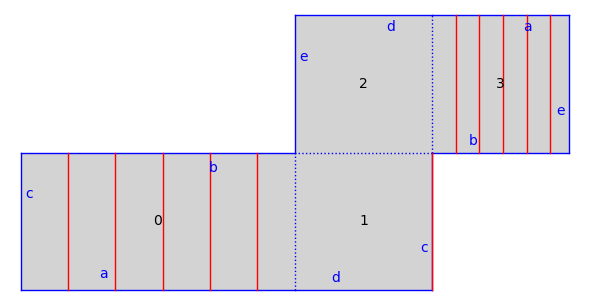


path: [1,6]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


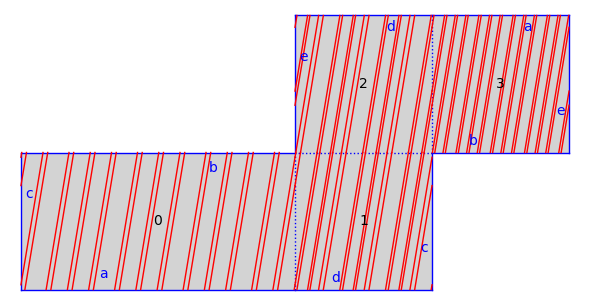


path: [2,6]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


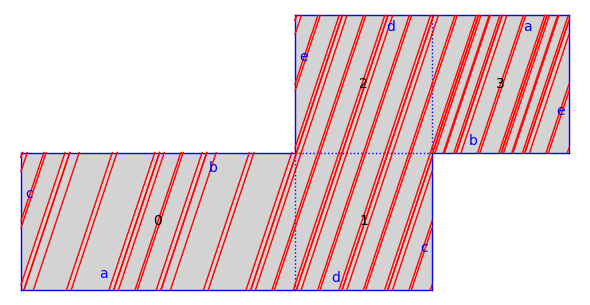


path: [3,6]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


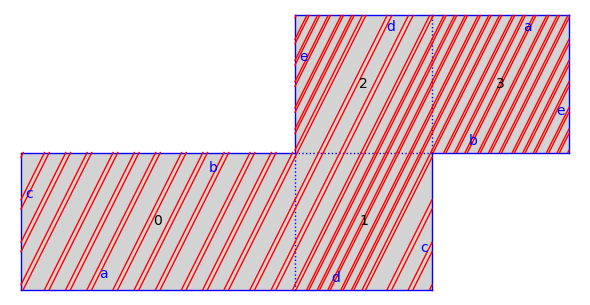


path: [4,6]
0. closed, not saddle.
1. closed, not saddle.
2. not closed, saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


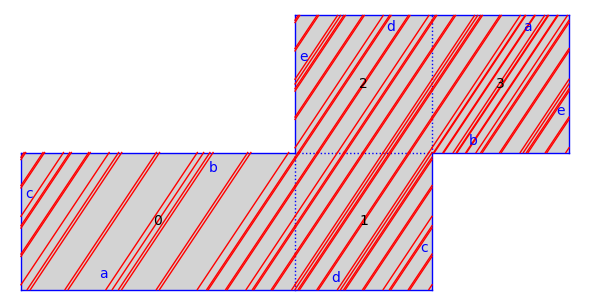


path: [0,7]
0. not closed, saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


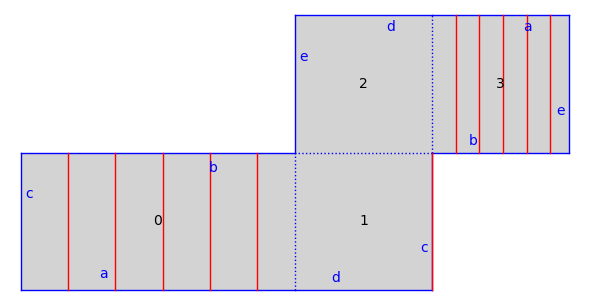


path: [1,7]
0. not closed, not saddle.
1. not closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. not closed, not saddle.
5. not closed, not saddle.


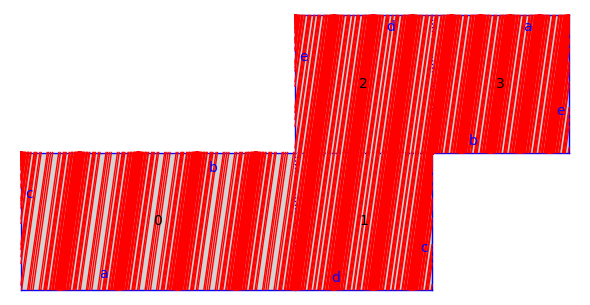


path: [2,7]
0. not closed, not saddle.
1. closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. closed, not saddle.
5. not closed, saddle.


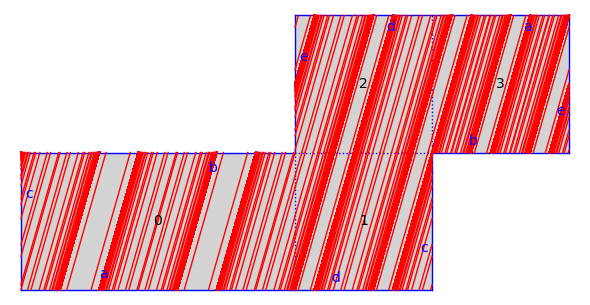


path: [3,7]
0. not closed, not saddle.
1. not closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. not closed, not saddle.
5. not closed, not saddle.


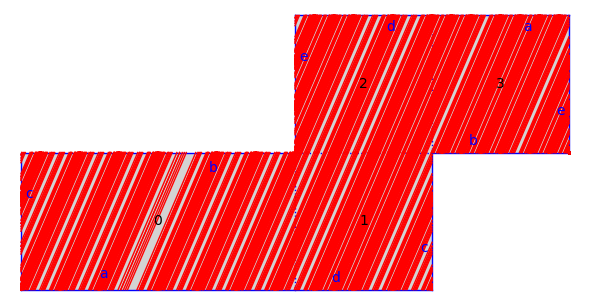


path: [4,7]
0. not closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. not closed, not saddle.
5. not closed, not saddle.


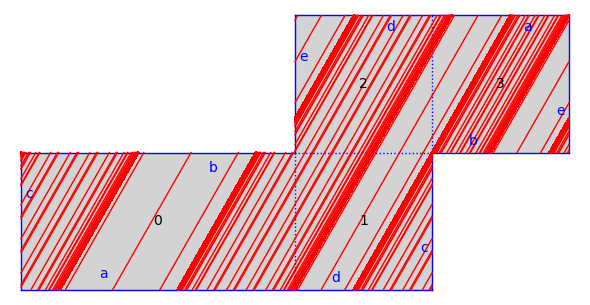


path: [0,8]
0. not closed, saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


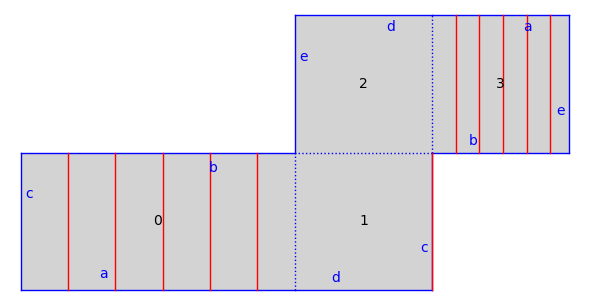


path: [1,8]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. not closed, saddle.
5. closed, not saddle.


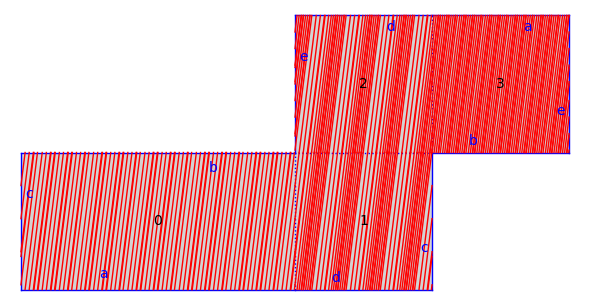


path: [2,8]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


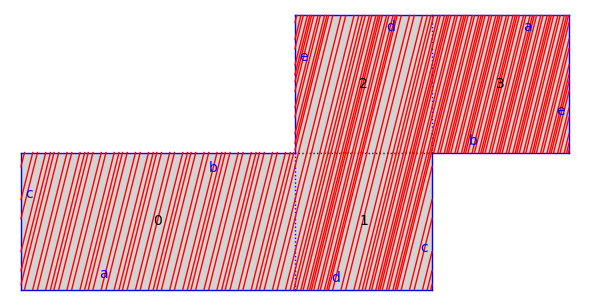


path: [3,8]
0. not closed, not saddle.
1. not closed, not saddle.
2. not closed, not saddle.
3. not closed, not saddle.
4. not closed, not saddle.
5. not closed, not saddle.


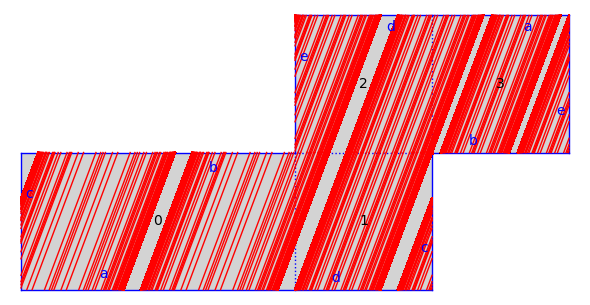


path: [4,8]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


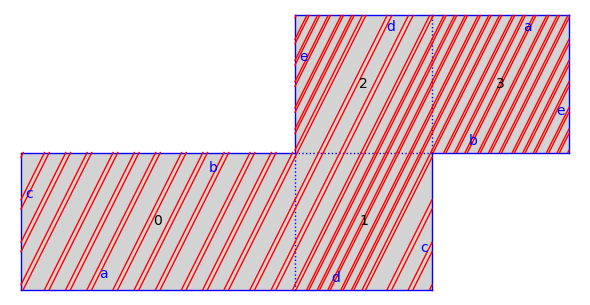


path: [0,9]
0. not closed, saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


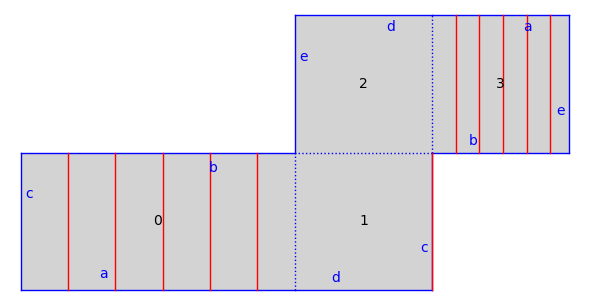


path: [1,9]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


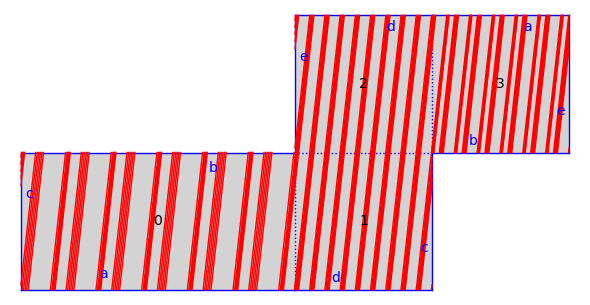


path: [2,9]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


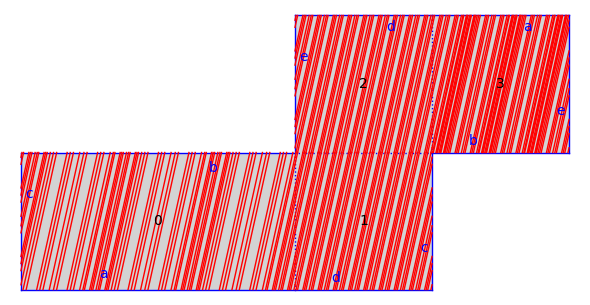


path: [3,9]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


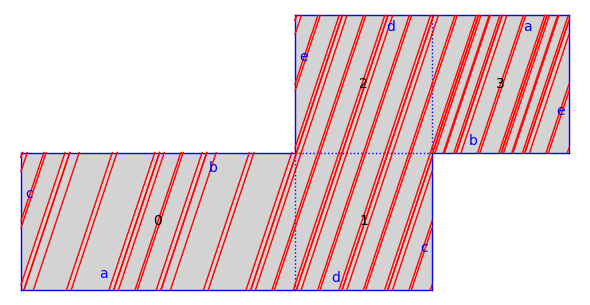


path: [4,9]
0. closed, not saddle.
1. closed, not saddle.
2. closed, not saddle.
3. closed, not saddle.
4. closed, not saddle.
5. closed, not saddle.


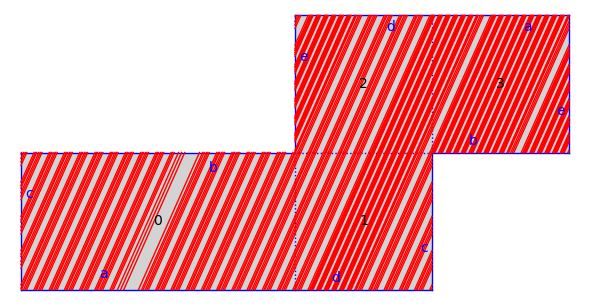

In [838]:
# Trying lots of vector trajectories. Most are closed.

for k in range(10)[5:]:
    for j in range(5):
        path = [j,k]
        print('\npath: [' + str(j) + ',' + str(k) + ']')

        trajs = []
        total = S.plot()
        for i in range(6):
            v = S.tangent_vector(0, ((i*10)/29, 1/29), path)
            traj = v.straight_line_trajectory()
            traj.flow(1000)
            traj.flow(-1000)
            total += traj.plot(color='red')
            print(str(i) + '. '+ 'not '*(not traj.is_closed()) + 'closed,' + ' not'*(not traj.is_saddle_connection()) + ' saddle.')
            
        total.show()

/private/var/tmp/sage-9.6-current/local/var/lib/sage/venv-python3.10.3/lib/python3.10/site-packages/sage/rings/qqbar.py:2865: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  roots = p.roots(ring, False)


/private/var/tmp/sage-9.6-current/local/var/lib/sage/venv-python3.10.3/lib/python3.10/site-packages/zmq/sugar/attrsettr.py:51: RuntimeWarning: cypari2 leaked 11809943008 bytes on the PARI stack
  return self._get_attr_opt(upper_key, opt)


ERROR: inconsistent avma when removing Gen from PARI stack
Expected: 0x2bfe56950
Actual:   0x2bfed94c8
IDR 2000/2000 --> 326.94 seconds


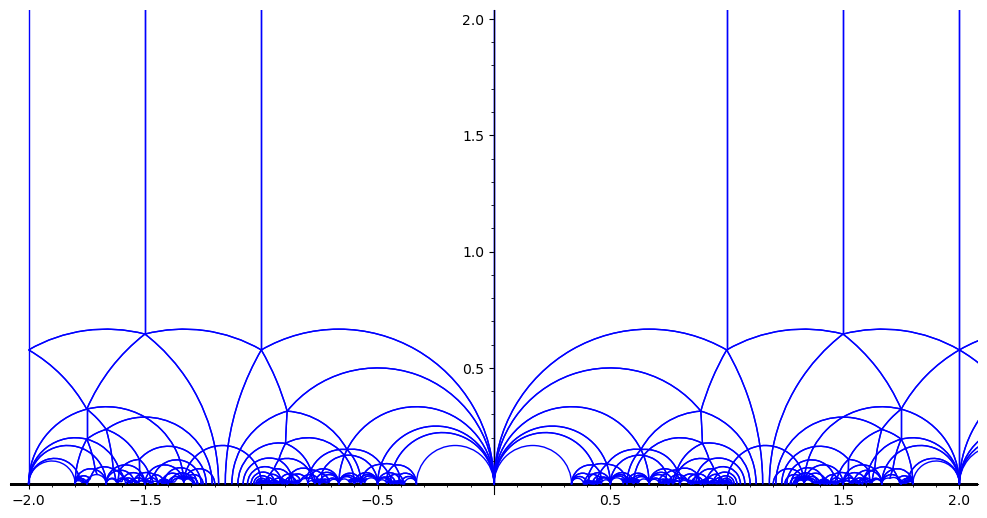

[
[161 144]  [ 119  180]  [ 121  180]  [ 65 -53]  [ 121 -180]
[180 161], [ -80 -121], [ -80 -119], [-38  31], [  80 -119],

[    47    -77]  [ 23/2  63/2]  [ 473/2   -107]  [-15 -32]  [ 21  11]
[-119/2  195/2], [ -7/2 -19/2], [-305/2     69], [  8  17], [-44 -23],

[ 23  11]  [ -797/4 -1157/4]  [ 29  20]  [ 23 -11]  [-23/2 -63/2]
[-44 -21], [ -549/4  -797/4], [-45 -31], [ 44 -21], [  7/2  19/2],

[-19/2 -63/2]  [-14  -5]  [-161  144]  [65 53]  [  797/4 -1157/4]
[  7/2  23/2], [-39 -14], [ 180 -161], [38 31], [ -549/4   797/4],

[   47    77]  [473/2   107]  [-31 -20]  [-1  6]  [ 479/2 -689/2]
[119/2 195/2], [305/2    69], [ 45  29], [ 0 -1], [-333/2  479/2],

[-15 -58]  [1 0]  [-23 -11]  [   -47     77]  [-121  180]  [-31  20]
[ -8 -31], [6 1], [ 44  21], [ 119/2 -195/2], [ -80  119], [-45  29],

[-1  0]
[ 0 -1]
]

In [81]:
all_veech_matrices = {}
DS, S, gs, s = dimple(2,1)
IDC1 = IDC(DS, 2000, veech = 1, show_current_sym = 0)
all_veech_matrices['2,1'] = [list(IDC1.generators(normalize_det=1)),S]
show(IDC1.plot(model = 'UHP', figsize = 10)) #UHP or KM
show(list(IDC1.generators(normalize_det=1)))

In [ ]:
# sage: cyl.holonomy()
# (3*a + 4, 2*a + 3)
# sage: cyl.edges()
# (2, 3, 3, 2, 4)
# cyl.polygons()
# b = cyl.boundary()

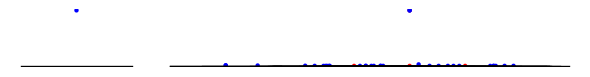

In [534]:
# Trying to plot the action of the veech group on sqrt(-1) = I.

UHP = HyperbolicPlane().UHP()

orbit = UHP.get_point(I).show(color = 'red')
orbit += UHP.get_point(1).show(color = 'red')
orbit += UHP.get_point(-1).show(color = 'red')
orbit += UHP.get_point(0).show(color = 'red')
    
points = [I]

for j in range(1):
    new_points = [moebius_transform(matrix(m),p) for m in matrices['2,1'] for p in points]
    points += new_points

for k in points:
    orbit += UHP.get_point(k).show()
    
orbit.plot()

In [754]:
from sage.plot.plot3d.shapes import *
A = Torus(.7, .2, color=(1,1,1)).translate(1,0,0)
A.show(frame=False)
# B = Torus(.7, .2, color=(1,1,1)).translate(2,0,0)
# C = A.intersection(B)
# C.show(frame=False)
# X = A + B
# X.show(frame=False)
# var('x,y,z')
# s1 = implicit_plot3d((x+y)*(x-z^3), (x,-2,2),(y,-2,2), (z,-2,2))
# s2 = implicit_plot3d(x*y+y^2, (x,-2,2),(y,-2,2), (z,-2,2), color="red")
# show(s1+s2)
# sol = solve([(x+y)*(x-z^3),x*y+y^2], [x,y,z])
# implicit_plot3d(((x+y)*(x-z^3))^2+(x*y+y^2)^2, (x,-2,2),(y,-2,2), (z,-2,2))
# x, y = AffineSpace(2, QQ, 'xy').gens()
# C2 = Curve(x^2 + y^2 - 1)
# C3 = Curve(x^3 + y^3 - 1)
# V = C2.intersection(C3)
# V.irreducible_components()

Graphics3d Object

In [767]:
import itertools
a = matrix([[1,3],[0,1]])
b = matrix([[1,3],[0,1]])
a*b

[1 6]
[0 1]